In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Very hacky, bad thing to do.
SRC_PATH = os.path.realpath('../src')
sys.path.append(SRC_PATH)

In [17]:
# Local imports.
from analysis import single_cycles
from defaults import PITCH_RATE, SAMPLE_RATE
from synthesis import EnvelopeMorpher, StimulusGenerator
from util import midi_to_hz, time_plot, stft_plot

In [18]:
# Synthesis parameters.
num_partials = 70
midi_pitch = 48
fm_depth = 0.1314
num_partials = 70
length = 2.
mod_rate = 5.
mod_hold = 0.
mod_fade = 0.
audio_fade = 0.2

# Calculations.
f0 = midi_to_hz(midi_pitch)

In [19]:
# Load env as linear amplitude. (CheapTrick calculates the power spectrum.)
env = single_cycles[0]['env']
env = np.sqrt(env)

## Experimental stimuli

The stimuli in this notebook are built off of the spectral envelopes from one cycle of vibrato, measured using the CheapTrick algorithm. In this case, the analysis is of a cello note playing C2. 

This notebook demonstates the following stimuli types:

The **BASIC** stimulus has both FM and the complex AM derived from scanning the
resonant structure of the instrument, as described by Mathews and others
(Mathews and Kohut, 1973), and serves as a positive control.

A **FROZEN** condition keeps the complex AM of a plausible resonant structure, but
contains no FM.

A **SHUFFLE** condition keeps the AM trajectory of each partial, but shuffles
the phase of each by a random quarter of the cycle: {0, π/2, π, 3π/2}.

The **SIMPLE** condition keeps the average spectral envelope and partial-wise
modulation depths of the original signal, but replaces the modulator signals
with one-cycle sinusoids all having the same modulation rate. Each partial takes
the time-averaged spectral envelope for its center amplitude. Partials are
amplitude-modulated such that their peak- and minimum- gains match the original
time-varying spectral envelope. The phase of these modulators is necessarily
randomized.

The random gain (**RAG**) condition is constructed much like the SIMPLE condition,
except its modulation depths are randomly determined per-partial to a value
between 0 – 10 dB according to the following formula:

$G_k = 20\log_{10}\left(\frac{\max p_k(t)}{\min p_k(t)}\right)$

where $G_k$ is the modulation depth of the kth partial, and $p_k(t)$ is the partial
amplitude. Random resonance gain has been used to construct compelling models of
vibrato in the past (Gough, 2005); though here by scrambling both partial phase
and gain, this condition effectively avoids implying any plausible resonant
structure.

The SHUFFLE, SIMPLE, and RAG conditions are also alternately synthesized in a
random AM frequency (**RAF**) condition. Here, each partial is amplitude modulated
at a frequency selected from a random exponential distribution between 4 Hz and
7 Hz, the span of commonly performed vibrato rates (Sundberg, 1987). We choose
an exponential distribution rather than a linear one, based on existing evidence
suggesting an exponential perceptual scaling of modulation rates (Grant, 1998).
Note that in this condition, the relative phase of the modulators is implicitly
randomized.

A control stimulus is included that has no AM or FM.

In all non-BASIC conditions, the partial gains are set to a "resting" value
measured from the time-varying spectral envelope at one quarter of a single
vibrato cycle, corresponding to the "middle" of the vibrato cycle. Only the
BASIC condition has FM. Parameters for all random stimuli are logged.

### Global settings

- `fm_depth` is the depth of frequency modulation in semitones.
- `num_partials` is the number of additive harmonic components in the synthesis.
- `length` is the length of the stimulus in seconds.
- `mod_rate` determines the cycle rate of the block of envelopes (in Hz).
- `mod_hold` is the time, in seconds, before the modulation starts.
- `mod_fade` is the ramp time, in seconds, to reach peak modulation depth.

Plain envelope


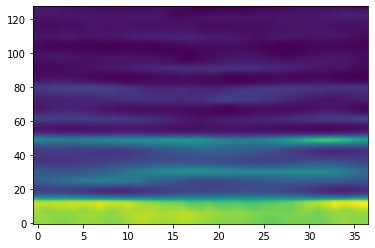

Shuffled envelope


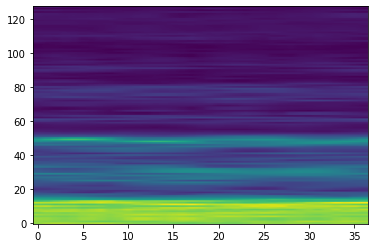

In [5]:
# Example modification of spectral envelopes.

morpher = EnvelopeMorpher(env)
print('Plain envelope')
morpher.show(zoom=8)

print('Shuffled envelope')
morpher.shuffle_phase(num_shifts=4)
morpher.show(zoom=8)

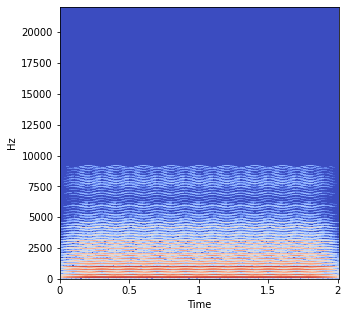

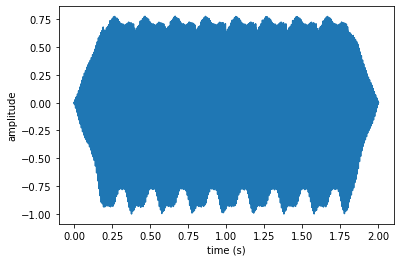

In [6]:
generator = StimulusGenerator(sr=SAMPLE_RATE, pr=PITCH_RATE)

# BASIC stimulus.
x = generator(
    f0=f0,
    fm_depth=fm_depth,
    env=env,
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

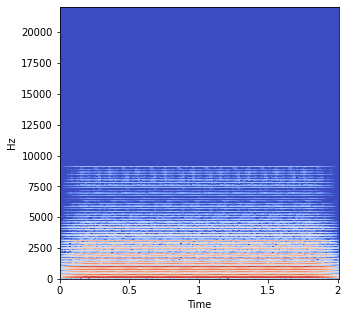

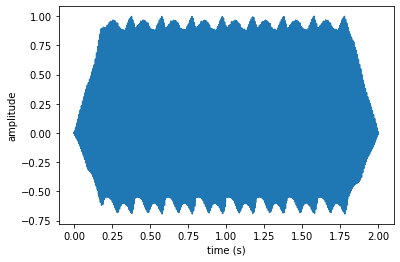

In [7]:
# FROZEN reconstruction condition (unmorphed, no FM).
x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

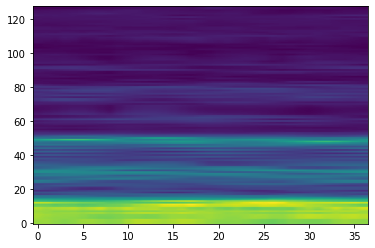

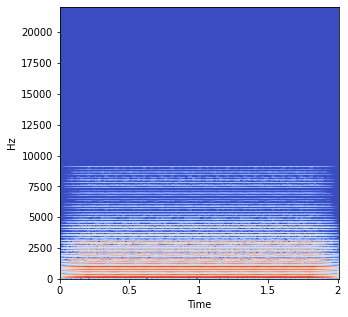

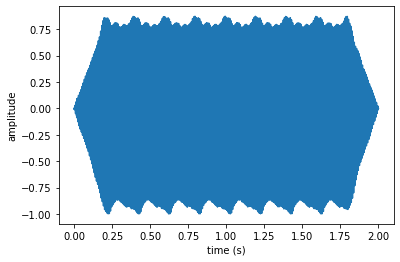

In [11]:
# SHUFFLE: amplitude modulation is phase-shuffled.

m0 = EnvelopeMorpher(env)
m0.shuffle_phase(num_shifts=4)
m0.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m0(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

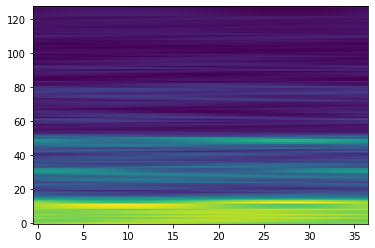

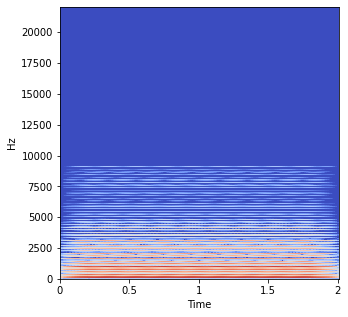

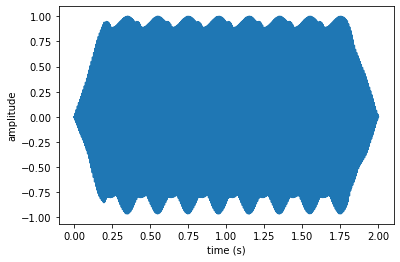

In [12]:
# SIMPLE: Smooth cycles following natural gain-depths.

m1 = EnvelopeMorpher(env)
m1.rap()
m1.shuffle_phase(num_shifts=4)
m1.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m1(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

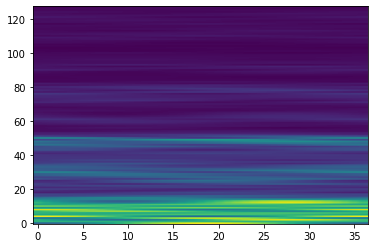

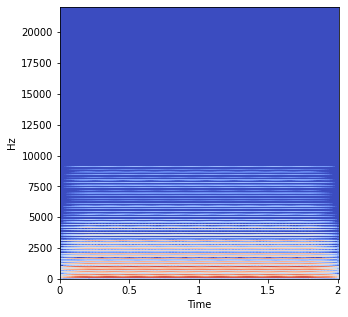

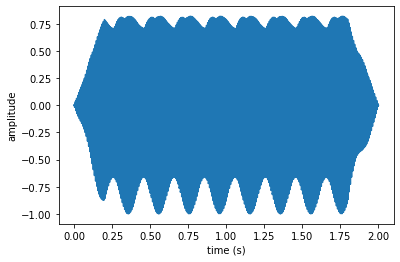

In [20]:
# RAG (Random amplitude gain): as above, now with randomized gains between 0 – 10 dB.

m2 = EnvelopeMorpher(env)
m2.rap(max_random_gain=10)
m2.shuffle_phase(num_shifts=4)
m2.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m2(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

## RAF: Random amplitude frequency

SHUFFLE, SIMPLE and RAG stimuli can also take on a RAF condition, where each partial is amplitude-modulated at a randomized frequency between 4 Hz – 7 Hz (by default; this property can be changed when instantiating a `generator` object).

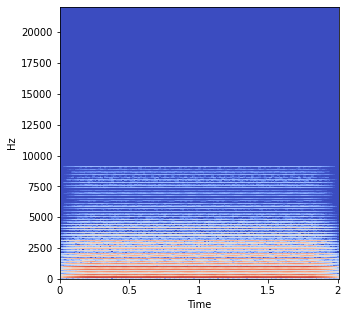

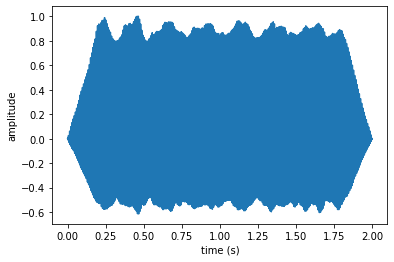

In [21]:
# SHUFFLE RAF
# (m0 is the phase-shuffled envelope.)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m0(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    synth_mode='raf',
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

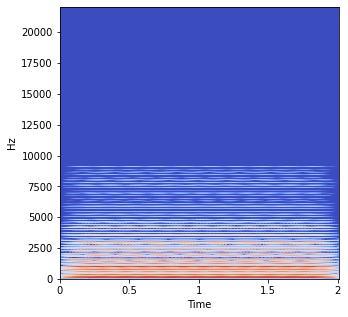

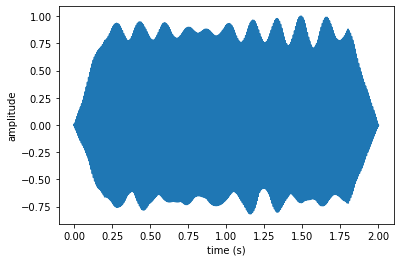

In [25]:
# SIMPLE RAF
# (m1 is the simplified phase-shuffled envelope.)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m1(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    synth_mode='raf',
    audio_fade=audio_fade,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

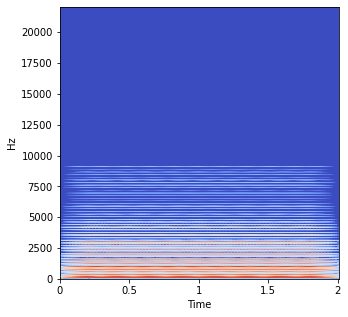

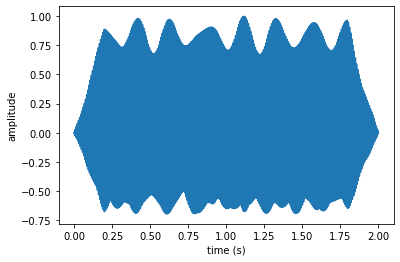

In [29]:
# RAG RAF.

# m2 envelope is randomized gains.

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m2(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
    synth_mode='raf',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

## Pure amplitude modulation (PAM) mode

Optionally, render a stimulus with the equivalent global amplitude envelope to any other stimulus.

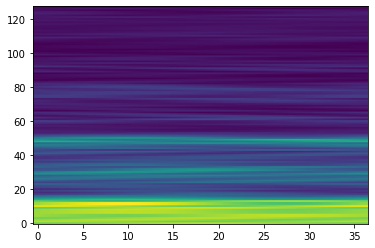

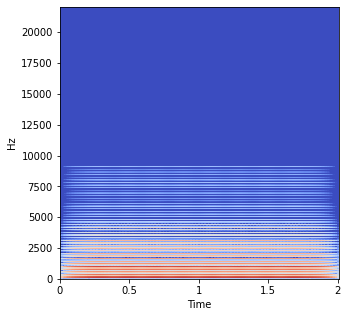

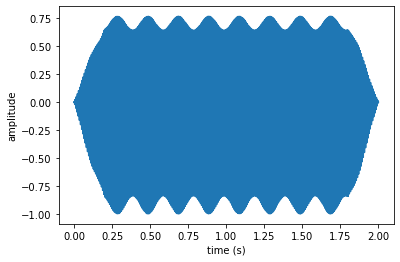

In [31]:
# PAM mode, pure amplitude modulation condition (a.k.a. tremolo).

m3 = EnvelopeMorpher(env)
m3.rap()
m3.shuffle_phase(num_shifts=4)
m3.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m3(),
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=mod_hold,
    mod_fade=mod_fade,
    audio_fade=audio_fade,
    synth_mode='pam',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

## Control without modulation

Generate a stimulus based on the average amplitude envelope.

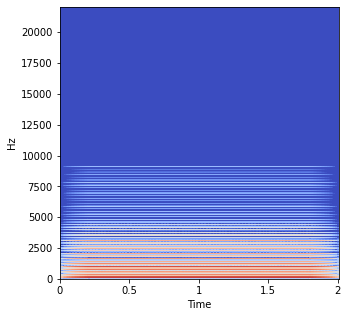

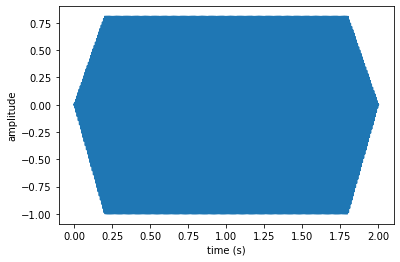

In [32]:
# Negative control.

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=num_partials,
    length=length,
    mod_rate=mod_rate,
    mod_hold=length,
    mod_fade=0,
    audio_fade=audio_fade,
    synth_mode='pam',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))